In [73]:
import keras
from keras import layers
import tensorflow as tf
import keras.backend as K
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

In [103]:
K.clear_session()

original_dim = (28, 28)
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(28, 28, 1))
conv1 = layers.Conv2D(16, kernel_size=(3, 3))(inputs)
conv1 = layers.MaxPooling2D((3, 3))(conv1)
h = layers.Flatten()(conv1)
z_mean = layers.Dense(latent_dim, name='z_mean')(h)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h)


In [104]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [105]:
t = keras.Model(inputs, [z_mean, z_log_sigma, z] )
t.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 16)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1024)         0           max_pooling2d[0][0]              
______________________________________________________________________________________________

In [102]:
intermediate_dim

64

In [107]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim, ), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Reshape()(x)
outputs = layers.UpSampling2D((3, 3))(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

ValueError: Input 0 of layer up_sampling2d_1 is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 64)

In [56]:
def vae_loss():
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 221.9508 - val_loss: 169.3590

KeyboardInterrupt: 

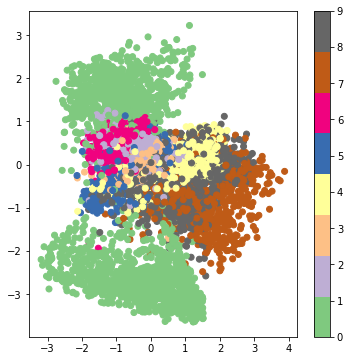

In [53]:
x_test_encoded = encoder.predict(x_test, batch_size=1024)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1],
            c=y_test, cmap=plt.cm.Accent)
plt.colorbar()
plt.show()

In [54]:
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           50240       input_5[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            130         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            130         dense_4[0][0]                    
____________________________________________________________________________________________